### I found this: https://machinelearningknowledge.ai/keras-implementation-of-resnet-50-architecture-from-scratch/  
### Learn it.  

Other Models: https://machinelearningknowledge.ai/popular-image-classification-models-in-imagenet-challenge-ilsvrc-competition-history/  


Interesting Materials:  
- https://towardsdatascience.com/cnn-resnets-a-more-liberal-understanding-a0143a3ddac9  
- https://www.quora.com/How-does-the-model-Faster-R-CNN-ResNet-50-work
- 


The concepts:  
1. Identity Block
   
   <img src="md_assets/image-20220829165058450.png" alt="image-20220829165058450" style="zoom:50%;" />
   
   
2. Convolutional Block  
   
   <img src="md_assets/image-20220829165634597.png" alt="image-20220829165634597" style="zoom:50%;" />  

   

In [2]:
import cv2
import numpy as np
import os

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from keras.models import Sequential, Model, load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Add, Dense, Activation, \
    ZeroPadding2D, BatchNormalization, Flatten, Conv2D, \
    AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, \
    MaxPool2D
from keras.initializers import glorot_uniform

---
---

Dataset from https://www.kaggle.com/datasets/karakaggle/kaggle-cat-vs-dog-dataset?resource=download  
Prepare the data.


In [3]:
train_path = "./datasets/train"
class_names = os.listdir(train_path)

test_path = "./datasets/test"
class_names_test = os.listdir(test_path)

print(class_names)
print(class_names_test)

['cat', 'dog']
['Cat', 'Dog']


In [22]:
image_dog = cv2.imread("./datasets/test/Dog/4501.jpg")
cv2.imshow('test dog', image_dog)
cv2.waitKey(0)

102

In [ ]:
image_cat = cv2.imread("./datasets/test/Cat/4501.jpg")
cv2.imshow('test cat', image_cat)
cv2.waitKey(0)

The ImageDataGenerator class defines the configuration for image data preparation and augmentation.  

In [4]:
train_datagen = ImageDataGenerator(zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.15)
test_datagen = ImageDataGenerator()

In [5]:
train_generator = train_datagen.flow_from_directory("./datasets/train", 
                                                    target_size=(224, 224), batch_size=32,
                                                    shuffle=True, class_mode='binary')
test_generator = test_datagen.flow_from_directory("./datasets/test", 
                                                  target_size=(224,224), batch_size=32,
                                                  shuffle=False, class_mode='binary')

Found 8992 images belonging to 2 classes.
Found 999 images belonging to 2 classes.


---
---

### Models:  (How to concat them ?)  


In [6]:
def identity_block(X, f, filters, stage, block):
    #     ------------------- X_shortcut -------------------
    #    |                                                 |
    # X - - CONV2D-BN-ReLU - CONV2D-BN-ReLU - CONV2D-BN - Add - ReLU 
    conv_name_base = 'res' + str(stage) + block + '_branch' # Conv2D
    bn_name_base   = 'bn'  + str(stage) + block + '_branch' # BatchNormalization
    F1, F2, F3 = filters                                    # Filter * 3

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same',  name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    #@ the input activation has the same dimension as the output activation
    X = Add()([X, X_shortcut]) # SKIP Connection
    X = Activation('relu')(X)

    return X


def convolutional_block(X, f, filters, stage, block, s=2):
    #     ------------- X_shortcut - CONV2D-BN -------------
    #    |                                                 |
    # X - - CONV2D-BN-ReLU - CONV2D-BN-ReLU - CONV2D-BN - Add - ReLU 
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base   = 'bn'  + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same',  name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    
    #* Deal with X_shortcut
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

ResNet50:  

<img src="md_assets/image-20220829181945440.png" alt="image-20220829181945440" style="zoom:50%;" />

In [7]:
def ResNet_50(input_shape=(224, 224, 3)): #!50 does not include the last avgpool and FC layer!

    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    #CONV2D[filters, kernel_size, strides, padding, name, kernel_initializer]
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    # [224,224,3]-Output[112,112]
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    # [112,112]-Output[56,56]

    # conv2_x * 3
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    # [56,56]-Output[56,56]
    
    # conv3_x * 4
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    # [56,56]-Output[28,28]
    
    # conv4_x * 6
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    # [28,28]-Output[14,14]
    
    # conv5_x * 3
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    # [14,14]-Output[7,7]

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    # [7,7]-Output[1,1]
    
    model = Model(inputs=X_input, outputs=X, name='ResNet_50')
    return model

### We need Transfer Learning!

In [8]:
base_model = ResNet_50(input_shape=(224, 224, 3))

headModel = base_model.output
headModel = Flatten()(headModel)
headModel = Dense(256, activation='relu', name='fc1', kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense(128, activation='relu', name='fc2', kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense(1, activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

model = Model(inputs=base_model.input, outputs=headModel)
#//model.summary()

2022-08-29 18:39:38.508512: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Load pre-trained weights:
1. Each layer has a parameter called “trainable”.   


2. For freezing the weights of a particular layer, we should set this parameter to False, indicating that this layer should not be trained. After that, we go over each layer and select which layers we want to train.

In [11]:
base_model.load_weights("./pretrained_w/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")
for layer in base_model.layers:
    layer.trainable = False

In [14]:
sgd = SGD(lr=0.0001, momentum=0.8, nesterov=True)
model.compile(optimizer=sgd, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

/Applications/anaconda3/envs/zeroShot/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', 
                verbose=1, patience=20)
mc = ModelCheckpoint('./pretrained_w//best_model.h5', 
                monitor='val_accuracy', mode='auto')

H = model.fit_generator(train_generator, validation_data=test_generator,
                    epochs=5, verbose=1, callbacks=[mc,es])

In best_model.h5:  

<img src="md_assets/image-20220829205710763.png" alt="image-20220829205710763" style="zoom:40%;" />  



---
---

### Evaluate:  (Here the same as val...)  

In [18]:
model.evaluate_generator(test_generator)

/var/folders/fc/n5827zt91vb65jnqcsgpv5cr0000gn/T/ipykernel_4968/2205837447.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator)


[0.07722947746515274, 0.9699699878692627]

### Save as Json file.

In [19]:
model_json = model.to_json()
with open("./json_res/model.json", "w") as json_file:
    json_file.write(model_json)

---
---
## Classification Inference 

In [46]:
from keras.models import model_from_json
from  matplotlib import pyplot as plt
%matplotlib inline

def predict_withResnet(image_path):
     
    json_file = open('./json_res/model.json', 'r')
    model_json_c = json_file.read()
    json_file.close()
    model_c = model_from_json(model_json_c)
    
    model_c.load_weights("./pretrained_w/best_model.h5")
    
    opt = SGD(lr=1e-4, momentum=0.9)
    model_c.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224,224))
    image = image[:,:,::-1]
    plt.imshow(image)
    plt.show()
    #//cv2.imshow("The Image to Be Classified: ", image)
    print("image has shape: ", image.shape)

    preds = model_c.predict(np.expand_dims(image, axis=0))[0]
    #!print(preds)
    if preds < 0.5:
        preds = 0
    else: 
        preds = 1
        
    if preds == 0:
        print("Predicted Label: Cat")
    else:
        print("Predicted Label: Dog")

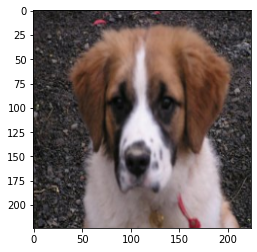

image has shape:  (224, 224, 3)
1/1 [==============================] - 1s 1s/step
Predicted Label: Dog


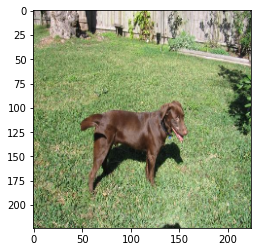

image has shape:  (224, 224, 3)
1/1 [==============================] - 1s 891ms/step
Predicted Label: Dog


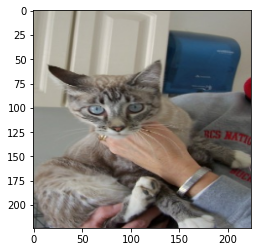

image has shape:  (224, 224, 3)
1/1 [==============================] - 1s 889ms/step
Predicted Label: Cat


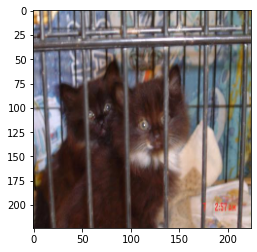

image has shape:  (224, 224, 3)
1/1 [==============================] - 1s 946ms/step
Predicted Label: Cat


In [49]:
predict_withResnet("./datasets/test/Dog/4505.jpg")
predict_withResnet("./datasets/test/Dog/4905.jpg")
predict_withResnet("./datasets/test/Cat/4505.jpg")
predict_withResnet("./datasets/test/Cat/4905.jpg") 

## Resnet:  
- https://www.bilibili.com/video/BV1T7411T7wa?spm_id_from=333.999.0.0&vd_source=b4c6848f0ca53aaf723f77170427ce41
- https://www.bilibili.com/video/BV1WE41177Ya?spm_id_from=333.999.0.0&vd_source=b4c6848f0ca53aaf723f77170427ce41
- (Tensorflow) https://github.dev/WZMIAOMIAO/deep-learning-for-image-processing/blob/master/tensorflow_classification/Test5_resnet/model.py 
- 